In [1]:
from os import getcwd, path, listdir, path
from pathlib import Path
from matplotlib.pyplot import axis, imshow, show, figure, title, subplot, plot, legend
from keras import layers, losses, optimizers, preprocessing, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras_cv import bounding_box, visualization, models, layers as cv_layers
from tensorflow import data, image, Tensor, image as tf_image, io, cast, float32
from numpy import argmax, concatenate

/Users/kiran/miniconda3/envs/algae_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


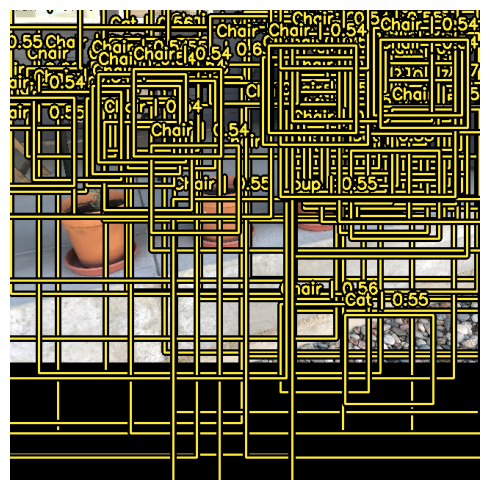

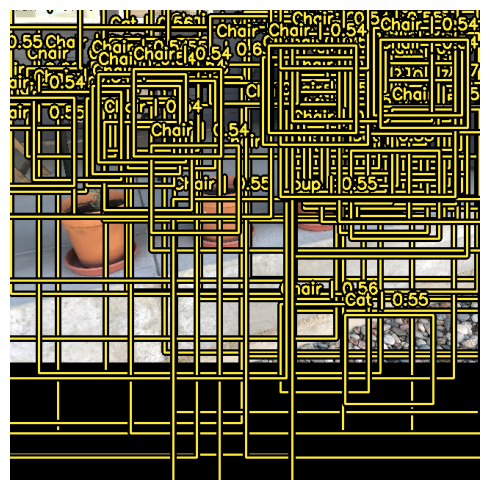

In [32]:
from keras import utils
from numpy import array

pretrained_model = models.YOLOV8Detector.from_preset("mobilenet_v3_small_imagenet", num_classes=3, bounding_box_format="xywh")

filepath = utils.get_file(origin="https://i.imgur.com/gCNcJJI.jpg")
image = utils.load_img(filepath)
image = array(image)

inference_resizing = cv_layers.Resizing(
    640, 640, pad_to_aspect_ratio=True,bounding_box_format="xywh"
)

image_batch = inference_resizing([image])

class_ids = [
    "Chair",
    "Cat",
    "pup",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

y_pred = pretrained_model.predict(image_batch)
# y_pred is a bounding box Tensor:
# {"classes": ..., boxes": ...}
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

# Constants

In [2]:
IMG_SIZE = 224
BATCH_SIZE = 16
VALIDATION_SPLIT = 0.2
SEED = 123
DS_PATH = path.join(Path(getcwd()).parents[0], 'dataset')
ALL_PATH = path.join(DS_PATH, 'all_data')
TRAIN_PATH = path.join(DS_PATH, 'train')
VALID_PATH = path.join(DS_PATH, 'valid')
CATEGORIES = sorted([ dir_name for dir_name in listdir(ALL_PATH) if path.isdir(path.join(ALL_PATH, dir_name)) ]) # DS_PATH

# Import dataset

In [3]:
def file_count(dir_name: str) -> int:
    return len(concatenate([i for _, i in dir_name], axis=0))
# pip install referencing -U
# pip install jsonschema -U

In [5]:
train_ds, valid_ds = preprocessing.image_dataset_from_directory(ALL_PATH,
                                                            #color_mode='grayscale',
                                                            subset='both',
                                                            label_mode='categorical',
                                                            validation_split=VALIDATION_SPLIT,
                                                            seed=SEED,
                                                            image_size=(IMG_SIZE, IMG_SIZE),
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=True
                                                            )

count = (2 * data.experimental.cardinality(valid_ds)) // 5
test_ds = valid_ds.take(count)
valid_ds = valid_ds.skip(count)

print("Using", file_count(test_ds), "files for testing and", file_count(valid_ds), "files for validation.")

Found 2447 files belonging to 5 classes.
Using 1958 files for training.
Using 489 files for validation.
Using 192 files for testing and 297 files for validation.


# Dataset visualization

In [11]:
# data_augmentation = Sequential([
#     layers.RandomFlip('horizontal_and_vertical'),
#     layers.RandomRotation(0.1),
#     # layers.RandomZoom(-0.1),
#     # layers.RandomTranslation(0.1, 0.1)
#     ])

def load_image(image_path):
    image = io.read_file(image_path)
    image = io.decode_jpeg(image)
    return image

def load_dataset(image_path):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": cast(CATEGORIES, dtype=float32),
        "boxes": Tensor(),#bbox,
    }
    return {"images": cast(image, float32), "bounding_boxes": bounding_boxes}

data_augmentation = Sequential(
    layers=[
        cv_layers.RandomFlip(mode="horizontal_and_vertical", bounding_box_format="xyxy"),
        cv_layers.RandomShear(x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"),
        #cv_layers.RandomRotation(factor=0.1, bounding_box_format="xyxy"),
        #cv_layers.RandomZoom(height_factor=(0.8, 1.2), width_factor=(0.8, 1.2), bounding_box_format="xyxy"),
        cv_layers.JitteredResize(target_size=(IMG_SIZE, IMG_SIZE), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"),
    ]
)

# def preprocess(img, label):
#     return data_augmentation(image.per_image_standardization(img)), label

train_ds = train_ds.map(load_dataset, num_parallel_calls=data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(data_augmentation, num_parallel_calls=data.AUTOTUNE)

resizing = cv_layers.JitteredResize(
    target_size=(IMG_SIZE, IMG_SIZE),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

valid_ds = valid_ds.map(load_dataset, num_parallel_calls=data.AUTOTUNE)
valid_ds = valid_ds.shuffle(BATCH_SIZE * 4)
valid_ds = valid_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
valid_ds = valid_ds.map(resizing, num_parallel_calls=data.AUTOTUNE)

TypeError: in user code:


    TypeError: outer_factory.<locals>.inner_factory.<locals>.tf__load_dataset() takes 1 positional argument but 2 were given


In [6]:
print(len(train_ds), 'total batches')

figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    print(images.shape, labels.shape)
    for i in range(9):
        ax = subplot(3, 3, i + 1)
        imshow(images[i].numpy().astype("uint8"))
        title(CATEGORIES[labels[i].numpy().argmax()])
        axis("off")

123 total batches


: 

In [ ]:
def visualize_dataset(ds):
    images, bounding_boxes = next(iter(ds.take(1)))
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        rows=2,
        cols=2,
        y_true=bounding_boxes,
        scale=3,
        font_scale=1,
        line_thickness=4,
        bounding_box_format="xyxy",
        legend=True
    )

visualize_dataset(train_ds)

visualize_dataset(valid_ds)

# Build and compile model

In [16]:
# Prefetching samples in GPU memory helps maximize GPU utilization
train_ds = train_ds.prefetch(data.AUTOTUNE).cache()
valid_ds = valid_ds.prefetch(data.AUTOTUNE).cache()
test_ds = test_ds.prefetch(data.AUTOTUNE).cache()

model = Sequential([
  layers.Input(shape=(images.shape[1:])),# batch_size=images.shape[0]),

  layers.Conv2D(filters=64, kernel_size=5, strides=2, activation='relu'),
  layers.MaxPooling2D(pool_size=3, strides=2),
  layers.BatchNormalization(momentum=0.9),

  layers.Conv2D(filters=64, kernel_size=5, strides=2, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=3, strides=1),
  layers.BatchNormalization(momentum=0.9),

  layers.Conv2D(filters=128, kernel_size=5, padding='same', strides=2, activation='relu'),
  layers.MaxPooling2D(pool_size=3, strides=1),
  layers.BatchNormalization(momentum=0.9),

  layers.Flatten(),

  layers.Dense(1024, activation='relu'),# input_shape=(prod(image_batch.shape[1:]),)),
  layers.BatchNormalization(momentum=0.9),

  layers.Dense(1024, activation='relu'),
  layers.BatchNormalization(momentum=0.9),
    
  layers.Dense(len(CATEGORIES), activation='softmax')
])

In [17]:
backbone = models.YOLOV8Backbone.from_preset("yolo_v8_xs_backbone")

100%|██████████| 631/631 [00:00<00:00, 530kB/s]


In [ ]:
yolo = models.YOLOV8Detector(
    num_classes=len(CATEGORIES),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)

In [8]:
def compile(model) -> None:
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
              loss=losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

    model.summary()

compile(model)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 110, 110, 64)      │      4,864 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 54, 54, 64)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization             │ (None, 54, 54, 64)        │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 64)        │    102,464 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_1           │ (None, 25, 25, 64)        │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 128)       │    204,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 11, 11, 128)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_2           │ (None, 11, 11, 128)       │        512 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 15488)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 1024)              │ 15,860,736 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_3           │ (None, 1024)              │      4,096 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 1024)              │  1,049,600 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_4           │ (None, 1024)              │      4,096 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 5)                 │      5,125 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 17,236,933 (65.75 MB)

 Trainable params: 17,232,325 (65.74 MB)

 Non-trainable params: 4,608 (18.00 KB)

# Train model

In [9]:
EPOCHS = 5
VERBOSE = 1
MONITOR = 'val_loss'
MODE = 'min'

def spe(dataset) -> int:
    return file_count(dataset) // BATCH_SIZE

EARLY = EarlyStopping(monitor=MONITOR,
                      patience=20,
                      verbose=VERBOSE,
                      mode=MODE,
                      restore_best_weights=True
                      )

def checkpoint(name: str) -> ModelCheckpoint:
    return ModelCheckpoint(name,
                           monitor=MONITOR,
                           verbose=VERBOSE,
                           save_best_only=True,
                           mode=MODE
                           )

def fit(model, filename: str):
    return model.fit(train_ds.repeat(),
                     validation_data=valid_ds.repeat(),
                     epochs=EPOCHS,
                     verbose=VERBOSE,
                     shuffle=True,
                     #steps_per_epoch=spe(train_ds),
                     #validation_steps=spe(valid_ds),
                     callbacks=[checkpoint(filename),EARLY]
                     )

history = fit(model, "model.keras")

Epoch 1/5
   1075/Unknown 252s 232ms/step - accuracy: 0.8067 - loss: 0.5703

KeyboardInterrupt: 

# Evaluate accuracy

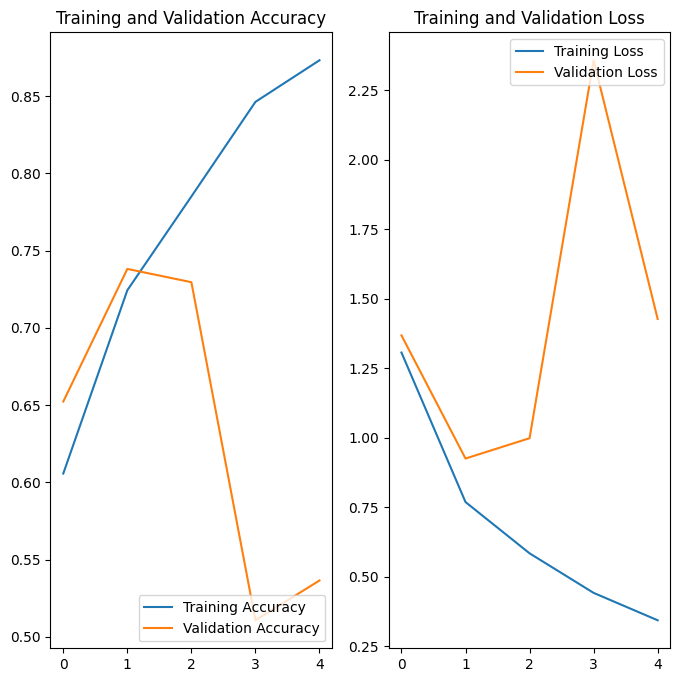

In [ ]:
acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
figure(figsize=(8, 8))
subplot(1, 2, 1)
plot(acc, label='Training Accuracy')
plot(val_acc, label='Validation Accuracy')
legend(loc='lower right')
title('Training and Validation Accuracy')

loss, val_loss = history.history['loss'], history.history['val_loss']
subplot(1, 2, 2)
plot(loss, label='Training Loss')
plot(val_loss, label='Validation Loss')
legend(loc='upper right')
title('Training and Validation Loss')
show()

# Testing and predicting

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6862 - loss: 0.9049
77.78% of predictions are correct


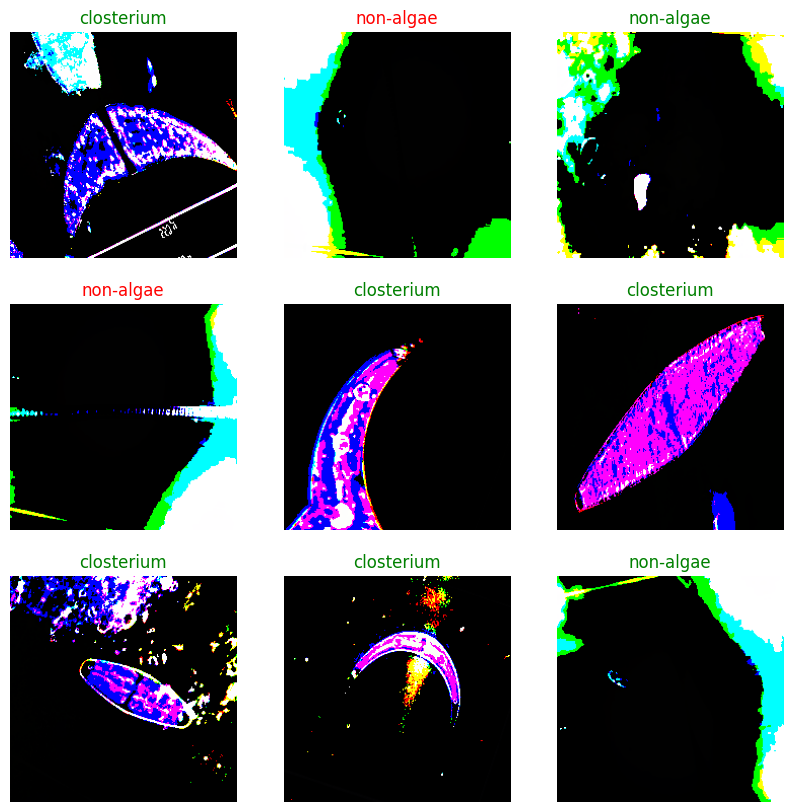

In [ ]:
model.evaluate(test_ds, verbose = 1)
probability_model = Sequential([model, layers.Softmax()])
prediction = probability_model.predict(test_ds, verbose = 0)
counter = 0

figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        predict = CATEGORIES[argmax(prediction[i])]
        correct = CATEGORIES[argmax(labels[i].numpy())]
        img = images[i].numpy().astype("uint8")

        ax = subplot(3, 3, i + 1)
        axis("off")
        imshow(img)

        if predict == correct:
            color = 'green'
            counter += 1
        else: color = 'red'

        title(predict, fontdict={'color': color})

print(f"{counter / 9 * 100:.2f}% of predictions are correct")